In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/street-view-house-nos-h5-file/SVHN_single_grey1.h5


## Let's load the data into the dictionary.

In [2]:
import h5py
filepath = '/kaggle/input/street-view-house-nos-h5-file/SVHN_single_grey1.h5'
data = {}
f = h5py.File(filepath)
for k, v in f.items():
    data[k] = np.array(v)
data.keys()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


dict_keys(['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val'])

In [3]:
def return_random_indices(data, max_samples=10000, seed = 10):
    np.random.seed(seed)
    indices = np.random.choice(np.arange(data.shape[0]),
                               max_samples,
                               replace=False)
    return indices


train_X = data["X_train"][return_random_indices(data["X_train"])]
train_y = data["y_train"][return_random_indices(data["y_train"])]
test_X = data["X_test"][return_random_indices(data["X_test"], 1000)]
test_y = data["y_test"][return_random_indices(data["y_test"], 1000)]
test_y[test_y == 10] = 0

In [4]:
train_X[0], train_y[:10], test_X[0], test_y[: 10]

(array([[125.0602, 126.0601, 126.946 , ..., 139.0111, 131.1259, 195.3951],
        [118.1641, 117.6803, 116.9685, ..., 138.837 , 130.9518, 195.808 ],
        [111.2402, 109.7565, 108.9307, ..., 139.065 , 131.0658, 195.808 ],
        ...,
        [ 98.0691, 103.0255, 110.5687, ..., 127.7519, 124.9802, 194.178 ],
        [108.2099, 114.2802, 121.3504, ..., 131.9364, 128.7518, 196.0638],
        [116.2199, 119.8066, 122.3503, ..., 134.0502, 130.2355, 196.3627]],
       dtype=float32),
 array([8, 7, 1, 3, 3, 5, 3, 9, 5, 3], dtype=uint8),
 array([[133.0173, 132.0174, 133.9032, ..., 121.9968, 122.9967, 124.2246],
        [129.5446, 128.5447, 131.0175, ..., 123.1107, 123.2247, 123.3387],
        [120.6595, 120.3606, 124.3602, ..., 119.2251, 119.3391, 119.752 ],
        ...,
        [ 98.8358, 101.8355, 110.8346, ...,  96.0857,  95.0858,  95.1998],
        [122.7194, 122.7194, 128.6048, ..., 110.9702, 109.9703, 110.9702],
        [145.7171, 143.1904, 144.0763, ..., 124.7408, 123.7409, 123.9689

## Data preparation for linear classifier.

In [5]:
def data_preparation(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones

## Why do we subtract means?

>Subtracting the dataset mean serves to "center" the data. Additionally, you ideally would like to divide by the sttdev of that feature or pixel as well if you want to normalize each feature value to a z-score.

>The reason we do both of those things is because in the process of training our network, we're going to be multiplying (weights) and adding to (biases) these initial inputs in order to cause activations that we then backpropogate with the gradients to train the model.

>We'd like in this process for each feature to have a similar range so that our gradients don't go out of control (and that we only need one global learning rate multiplier).

>Another way you can think about it is deep learning networks traditionally share many parameters - if you didn't scale your inputs in a way that resulted in similarly-ranged feature values (ie: over the whole dataset by subtracting mean) sharing wouldn't happen very easily because to one part of the image weight w is a lot and to another it's too small.
**[Source](https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current#:~:text=5%20Answers&text=Subtracting%20the%20dataset%20mean%20serves,value%20to%20a%20z%2Dscore.)

In [6]:
train_X, test_X = data_preparation(train_X, test_X)
train_X[0], test_X[-1], train_X.shape

(array([0.03989474, 0.0436459 , 0.04685752, ..., 0.06198489, 0.32023929,
        1.        ]),
 array([-0.07499233, -0.06787566, -0.07406522, ..., -0.01374571,
        -0.00554543,  1.        ]),
 (10000, 1025))

## Randomly split train data into train and validation datasets.

In [7]:
def random_split_train_val(X, y, num_val, seed=25):
    '''
    Randomly splits dataset into training and validation.
    
    Args:
    X (numpy array): an array of training samples.
    y (numpy array): an array of training labels.
    num_val (int): a number of samples to put into validation dataset.
    seed (int): a seed for pseudo random number generator.
    
    Returns:
    train_X (numpy array): a training dataset of samples.
    train_y (numpy array): a training dataset of labels.
    val_X (numpy array): a validation dataset of samples.
    val_y (numpy array): a validation dataset of labels.
    '''
    np.random.seed(seed)
    
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    train_indices = indices[:-num_val]
    train_X = X[train_indices]
    train_y = y[train_indices]

    val_indices = indices[-num_val:]
    val_X = X[val_indices]
    val_y = y[val_indices]

    return train_X, train_y, val_X, val_y

In [8]:
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

## In this assignment we will learn how to calculate gradient of function by calculating the estimation of function's derivative ([numeric method](https://en.wikipedia.org/wiki/Numerical_differentiation)). 

Another two-point formula is to compute the slope of a nearby secant line through the points (x - h, f(x − h)) and (x + h, f(x + h)). The slope of this line is.
This formula is known as the symmetric difference quotient. In this case the first-order errors cancel, so the slope of these secant lines differ from the slope of the tangent line by an amount that is approximately proportional to {\displaystyle h^{2}}h^{2}. Hence for small values of h this is a more accurate approximation to the tangent line than the one-sided estimation. However, although the slope is being computed at x, the value of the function at x is not involved.

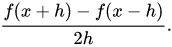

In [9]:
def check_gradient(f, x, delta=1e-5, tol = 1e-4, verbose=False):
    '''
    Checks the implementation of analytical gradient by comparing
    it to numerical gradient using two-point formula.
    
    Args:
      f (func): a function that receives x and computes value and gradient.
      x (numpy array of float): an initial point where gradient is checked.
      delta (float): a step to compute numerical gradient.
      tol (float): a tolerance for comparing numerical and analytical gradients.
      
    Returns:
      (bool): an indication whether gradients are match or mismatch.
    '''
    
    assert isinstance(x, np.ndarray)
    assert x.dtype == np.float
    
    orig_x = x.copy()
    fx, analytic_grad = f(x)
    assert np.all(np.isclose(orig_x, x, tol)), f'Functions shouldn t modify input variables {orig_x, x}.'
    # np.isclose returns a boolean array where two arrays are element-wise equal within a tolerance.

    assert analytic_grad.shape == x.shape
    analytic_grad = analytic_grad.copy()
    
    if x is not np.array:
        x = np.array(x)
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        value = x[ix]
        x[ix] = value + delta
        fx_plus_delta = f(x)
        x[ix] = value - delta
        fx_minus_delta = f(x)
        x[ix] = value # restore value
        grad[ix] = (fx_plus_delta[0] - fx_minus_delta[0]) / (2 * delta)
        
        if verbose:
            print(ix, grad[ix])
                     
        analytic_grad_at_ix = analytic_grad[ix]
        numeric_grad_at_ix = grad[ix]
        
        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (ix, analytic_grad_at_ix, numeric_grad_at_ix))
            #return False
        
        it.iternext()

    print("Gradient check passed!")
    return

In [10]:
def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


Here we'll write [Softmax function](https://en.wikipedia.org/wiki/Softmax_function) for multinomial logistic regression and is often used as the last activation function of a neural network to normalize the output of a network to a probability distribution over predicted output classes.
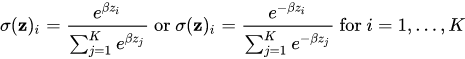

In [11]:
def softmax(input_values):
    '''
    Computes probabilities from scores.
    
    Args:
      input_values (numpy array shape (N,) or (batch_size, N)): a classifier output.
      
    Returns:
      estimated_probabilities (numpy array of the same shape as input values): an estimated probability
      for every class.
    '''
    try:
        values = input_values.copy()
        if values.ndim == 1:
            values -= np.max(values)#  shift values inside the vector for numeric stability of rapidly
                                    #  increasing exponential function.
            estimated_probabilities = np.exp(values) / np.sum(np.exp(values))
        else:
            max_values = np.max(values, axis=1).reshape(-1,1)
            values = values - max_values
            estimated_probabilities = np.exp(values) / np.sum(np.exp(values), axis = 1).reshape(values.shape[0], -1)
        
        return estimated_probabilities
    
    except:
        raise Exception("Not implemented!")

In [12]:
softmax(np.array([-10, 0, 10]))

array([2.06106005e-09, 4.53978686e-05, 9.99954600e-01])

In [13]:
probs = softmax(np.array([-10, 0, 10]))

probs = softmax(np.array([1000, 0, 0]))

assert np.isclose(probs[0], 1.0)

We will write a [cross-entropy loss function](https://en.wikipedia.org/wiki/Cross_entropy). This function will serves as error function for our linear classifier.

The cross-entropy between two probability distributions __p__ and __q__ over the same underlying set of events measures the average number of bits needed to identify an event drawn from the set if a coding scheme used for the set is optimized for an estimated probability distribution __q__, rather than the true distribution __p__.

For discrete probability distributions __p__ and __q__ with the same support this means:

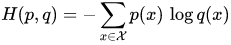

In [14]:
def cross_entropy_loss(estimated_distribution, target_index, epsilon=1e-12):
    '''
    Computes cross-entropy loss.
    
    Args:
      estimated_distribution (numpy array, shape (N,) or (batch_size, N)): probabilities for every class.
      target_index (numpy array of int, shape (1,) or (batch_size,)): index of the true class 
      in given sample(s), showing at which index an estimated distibution should be max.
      
    Returns:
      a single value.
    '''
    try:
        if target_index is not np.array:
            target_index = np.array(target_index)
        
        if estimated_distribution.ndim == 1:
            estimated_distribution = estimated_distribution.reshape(1,-1)
            
        rows = estimated_distribution.shape[0]
        true_distribution = np.zeros_like(estimated_distribution)
        columns = target_index.flatten()
        true_distribution[np.arange(rows), columns] = 1
        return - np.sum(true_distribution * np.log(estimated_distribution))
    except:
        raise Exception("Not implemented!")

In [15]:
probs = softmax(np.array([-5, 0, 5]))
probs

array([4.50940412e-05, 6.69254912e-03, 9.93262357e-01])

In [16]:
cross_entropy_loss(probs, 1)

5.006760443547122

To use the softmax function in neural networks, we need to compute its derivative. If we define \begin{split} \Sigma_C = \sum_{d=1}^C e^{z_d} \, \text{for} \; c = 1 \cdots C so that y_c = e^{z_c} / \Sigma_C \end{split} then this derivative \begin{split} {\partial y_i}/{\partial z_j} \end{split} of the output y of the softmax function with respect to its input z can be calculated as:

\begin{split}
\text{if} \; i = j :& \frac{\partial y_i}{\partial z_i} = \frac{\partial \frac{e^{z_i}}{\Sigma_C}}{\partial z_i} = \frac{e^{z_i}\Sigma_C - e^{z_i}e^{z_i}}{\Sigma_C^2} = \frac{e^{z_i}}{\Sigma_C}\frac{\Sigma_C - e^{z_i}}{\Sigma_C} = \frac{e^{z_i}}{\Sigma_C}(1-\frac{e^{z_i}}{\Sigma_C}) =  y_i (1 - y_i)\\
\text{if} \; i \neq j :& \frac{\partial y_i}{\partial z_j} = \frac{\partial \frac{e^{z_i}}{\Sigma_C}}{\partial z_j} = \frac{0 - e^{z_i}e^{z_j}}{\Sigma_C^2} = -\frac{e^{z_i}}{\Sigma_C} \frac{e^{z_j}}{\Sigma_C} = -y_i y_j
\end{split}

Cross-entropy loss function:

\begin{split}
\xi(T,Y) = \sum_{i=1}^n \xi(\mathbf{t}_i,\mathbf{y}_i) = -\sum_{i=1}^n \sum_{c=1}^{C} t_{ic} \cdot \log( y_{ic})\end{split}


The derivative \begin{split}{\partial \xi}/{\partial z_i}\end{split} of the loss function with respect to the softmax input zi can be calculated as:

\begin{split}
\frac{\partial \xi}{\partial z_i} & = - \sum_{j=1}^C \frac{\partial t_j \log(y_j)}{\partial z_i}{} 
= - \sum_{j=1}^C t_j \frac{\partial \log(y_j)}{\partial z_i} 
= - \sum_{j=1}^C t_j \frac{1}{y_j} \frac{\partial y_j}{\partial z_i} \\
& = - \frac{t_i}{y_i} \frac{\partial y_i}{\partial z_i} - \sum_{j \neq i}^C \frac{t_j}{y_j} \frac{\partial y_j}{\partial z_i}
= - \frac{t_i}{y_i} y_i (1-y_i) - \sum_{j \neq i}^C \frac{t_j}{y_j} (-y_j y_i) \\
& = - t_i + t_i y_i + \sum_{j \neq i}^C t_j y_i = - t_i + \sum_{j = 1}^C t_j y_i
= -t_i + y_i \sum_{j = 1}^C t_j \\
& = y_i - t_i
\end{split}
[Source](https://peterroelants.github.io/posts/cross-entropy-softmax/)

In [17]:
def softmax_with_cross_entropy(input_values, target_index):
    '''
    Computes softmax and cross-entropy loss for model predictions,
    including the gradient.
    
    Args:
      input_values (numpy array, shape (N,) or (batch_size, N)): a classifier output.
      target_index (numpy array of int, shape (1,) or (batch_size,)): an index of the true 
      class for given sample(s).
      
    Returns:
      loss (a single value): cross-entropy loss.
      gradient (numpy array, input_values.shape): a gradient of cross entopy error function
      with a softmax derivative.
    '''
    try:            
        estimated_distribution = softmax(input_values)
        loss = cross_entropy_loss(estimated_distribution, target_index)
        
        if estimated_distribution.ndim == 1:
            estimated_distribution = estimated_distribution.reshape(1,-1)
            
        rows = estimated_distribution.shape[0]
        true_distribution = np.zeros_like(estimated_distribution)
        
        if target_index is not np.array:
            target_index = np.array(target_index)
        
        columns = target_index.flatten()
        true_distribution[np.arange(rows), columns] = 1
        gradient = estimated_distribution - true_distribution
        if input_values.ndim == 1:
            gradient = gradient.reshape(input_values.shape) # done only for gradient check
        return loss, gradient
    except:
        raise Exception("Not implemented!")

In [18]:
loss, grad = softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


In [19]:
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!


In [20]:
num_classes = 4
# Test batch_size = 3
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!


In [21]:
# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

### Let's create a linear classifier.

In [22]:
def linear_softmax(X, W, target_index):
    '''
    Performs linear classification and returns loss and gradient over W.
    
    Args:
      X (numpy array, shape (num_batch, num_features)): batch of images.
      W (numpy array, shape (num_features, classes)): weights.
      target_index (numpy array, shape (num_batch)): index of target classes.
      
    Returns:
      loss (single value): cross-entropy loss.
      gradient (numpy array same shape as W): gradient of weight by loss.
    '''
    try:
        predictions = np.dot(X, W)
        estimated_distribution = softmax(predictions)
        loss = cross_entropy_loss(estimated_distribution, target_index)
        
        if estimated_distribution.ndim == 1:
            estimated_distribution = estimated_distribution.reshape(1,-1)
            
        rows = estimated_distribution.shape[0]
        true_distribution = np.zeros_like(estimated_distribution)
        
        if target_index is not np.array:
            target_index = np.array(target_index)
        
        columns = target_index.flatten()
        true_distribution[np.arange(rows), columns] = 1
        gradient = estimated_distribution - true_distribution
        dW = np.dot(X.T, gradient)
        return loss, dW
    except:
        raise Exception("Not implemented!")

In [23]:
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_softmax(X, W, target_index)
print(f'Loss {loss}, gradient over weights {dW}.')
check_gradient(lambda w: linear_softmax(X, w, target_index), W)

Loss 2.1755153626167147, gradient over weights [[-0.88079708  0.88079708]
 [-0.8333712   0.8333712 ]
 [ 0.92822295 -0.92822295]].
Gradient check passed!


In [24]:
def l2_regularization(W, reg_strength):
    '''
    Computes L2 regularization loss on weights and its gradient.
    
    Arguments:
      W, np array - weights
      reg_strength - float value
    Returns:
      loss, single value - l2 regularization loss
      gradient, np.array same shape as W - gradient of weight by l2 loss
    '''
    try:
        l2_regularization_loss = reg_strength * np.sum(np.square(W))
        gradient = 2 * reg_strength * W
        return l2_regularization_loss, gradient
    # TODO: implement l2 regularization and gradient
    # Your final implementation shouldn't have any loops
    except:
        raise Exception("Not implemented!")

In [25]:
loss, grad = l2_regularization(W, 0.01)
print(f'Loss {loss}, grad {grad}.')
check_gradient(lambda w: l2_regularization(w, 0.01), W)

Loss 0.12, grad [[ 0.02  0.04]
 [-0.02  0.02]
 [ 0.02  0.04]].
Gradient check passed!


## Train

In [26]:
class LinearSoftmaxClassifier():
    def __init__(self):
        self.W = None

    def fit(self, X, y, batch_size=100, learning_rate=1e-7, reg=1e-5,
            epochs=1, verbose=False):
        '''
        Trains linear classifier
        
        Arguments:
          X, np array (num_samples, num_features) - training data
          y, np array of int (num_samples) - labels
          batch_size, int - batch size to use
          learning_rate, float - learning rate for gradient descent
          reg, float - L2 regularization strength
          epochs, int - number of epochs
        '''

        num_train = X.shape[0]
        num_features = X.shape[1]
        num_classes = np.max(y) + 1
        if self.W is None:
            self.W = 0.001 * np.random.randn(num_features, num_classes)
        try:
            loss_history = []
            for epoch in range(epochs):
                shuffled_indices = np.arange(num_train)
                np.random.shuffle(shuffled_indices)
                sections = np.arange(batch_size, num_train, batch_size)
                batches_indices = np.array_split(shuffled_indices, sections)
                for bi in batches_indices:
                    batch_X = X[bi]
                    batch_y = y[bi]
                    loss, gradient = linear_softmax(batch_X, self.W, batch_y)
                    l2_reg_loss_cost, grad_l2_reg_loss_cost = l2_regularization(self.W, reg)
#                     loss_history.append(loss)
                    loss = loss + l2_reg_loss_cost
                    gradient = gradient + grad_l2_reg_loss_cost
                    loss_history.append(loss)
                    self.W = self.W - learning_rate * gradient
                if verbose:
                    print("Epoch %i, loss: %f" % (epoch, loss))

            return loss_history
        except:
            raise Exception("Not implemented!")

    def predict(self, X):
        '''
        Produces classifier predictions on the set
       
        Arguments:
          X, np array (test_samples, num_features)
        Returns:
          y_pred, np.array of int (test_samples)
        '''
        try:
            y_pred = np.zeros(X.shape[0], dtype=np.int)
            predictions = np.argmax(softmax(np.dot(X, self.W)), axis=1)
            y_pred = predictions
            return y_pred
        except:
            raise Exception("Not implemented!")

In [27]:
classifier = LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

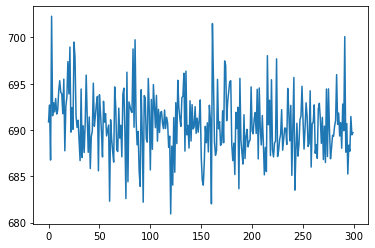

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss_history)

## Let's check how it performs on validation set.

In [29]:
def multiclass_accuracy(prediction, ground_truth):
    '''
    Computes metrics for multiclass classification.
    
    Args:
        prediction (numpy array of int): model predictions.
        ground_truth (numpy array of int): true labels.
        
    Returns:
        accuracy: ratio of accurate predictions to total samples.
    '''
    confusion_matrix = np.zeros((10,10), np.int)
    np.add.at(confusion_matrix, [prediction, ground_truth], 1)
    accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()
    return accuracy

In [30]:
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

Accuracy:  0.149


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


## # Now, let's train more and see if it performs better.

In [31]:
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy after training for 100 epochs:  0.155


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


## Cross-Validation

In [32]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

accuracies = list()
parameters = list()
models = list()

for lr in learning_rates:
    for r in reg_strengths:
        classifier = LinearSoftmaxClassifier()
        loss_history = classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=300, reg=r)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        accuracies.append(accuracy)
        parameters.append((lr, r))
        models.append(classifier)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


In [33]:
best_accuracy = max(accuracies)
index_of_the_best = accuracies.index(best_accuracy)
best_classifier = models[index_of_the_best]
best_parameters = parameters[index_of_the_best]
print(f'The best of accuracy on validatio data is {best_accuracy} at learning rate {best_parameters[0]} and regulation strength {best_parameters[1]}.')

The best of accuracy on validatio data is 0.213 at learning rate 0.0001 and regulation strength 0.0001.


In [34]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print(f'Linear softmax classifier test set accuracy: {test_accuracy}')

Linear softmax classifier test set accuracy: 0.212


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
